In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets,transforms,models
from torch.utils.data import DataLoader
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
import joblib
import matplotlib.image as mpimg
import os

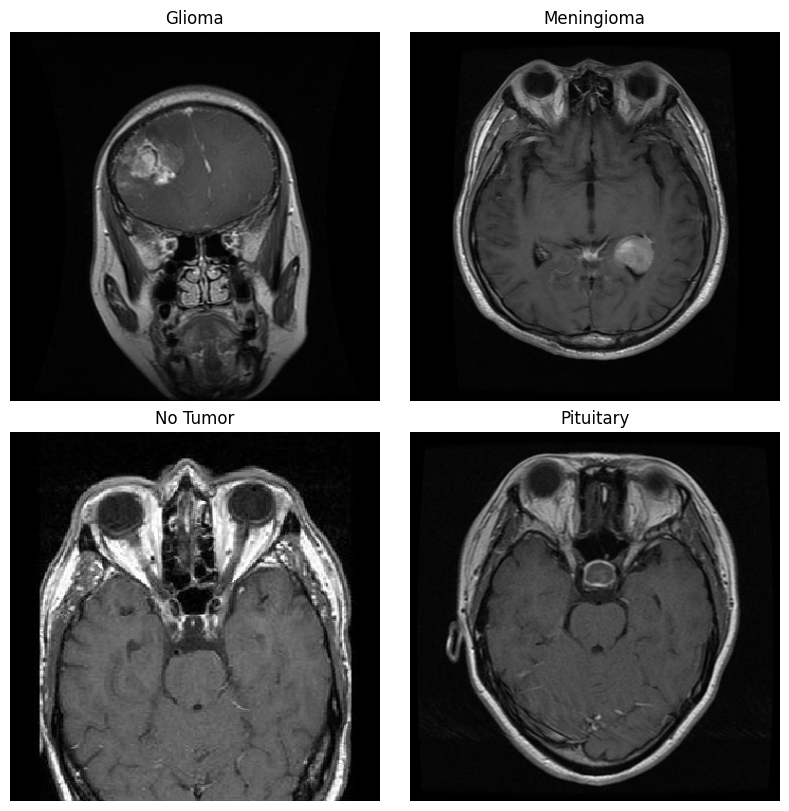

In [2]:
fig, axes = plt.subplots(2, 2, figsize=(8, 8), constrained_layout=True)
images = [('/kaggle/input/brain-tumor-mri-dataset/Training/glioma/Tr-glTr_0000.jpg','Glioma'),
         ('/kaggle/input/brain-tumor-mri-dataset/Training/meningioma/Tr-meTr_0001.jpg','Meningioma'),
         ('/kaggle/input/brain-tumor-mri-dataset/Training/notumor/Tr-noTr_0000.jpg','No Tumor'),
         ('/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-piTr_0001.jpg','Pituitary')]
for i, (image_path, label) in enumerate(images):
    img = mpimg.imread(image_path)
    ax = axes.flat[i]
    ax.imshow(img)
    ax.set_title(label, color='Black',fontsize=12)
    ax.axis('off')
    
    
plt.show()

In [3]:
data_path = '/kaggle/input/brain-tumor-mri-dataset/Training'
batch_size = 32
learning_rate = 0.001
epochs = 200
output_dim = 4
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

In [4]:
# DATA AUGMENTATION
transform = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean,std=std)
])

In [5]:
dataset = datasets.ImageFolder(data_path,transform=transform)
train_size = int(len(dataset)*0.8)
val_size = len(dataset)-train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])

In [6]:
train_loader = DataLoader(train_dataset,batch_size=batch_size, shuffle=True,num_workers=4)
val_loader = DataLoader(val_dataset,batch_size=batch_size, shuffle=False,num_workers=4)

In [7]:
# CUSTOM U-NET FEATURE EXTRACTOR
class UNetFeatureExtractor(nn.Module):
    def __init__(self,pretrained=False):
        super(UNetFeatureExtractor, self).__init__()
        self.encoder = models.resnet152(pretrained=pretrained)
        self.encoder_layers = list(self.encoder.children())[:-2]
        self.encoder = nn.Sequential(*self.encoder_layers)
        
    def forward(self,x):
        features = self.encoder(x)
        return features

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
feature_extractor = UNetFeatureExtractor(pretrained=True).to(device)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:01<00:00, 187MB/s]


In [9]:
def apply_pca(features,pca):
    flat_features = features.view(features.size(0),-1).detach().cpu().numpy()
    pca_features = pca.transform(flat_features)
    return pca_features

In [10]:
class ANNClassifier(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(ANNClassifier, self).__init__()
        self.block = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128,256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,256),
            nn.ReLU(),
            nn.Linear(256, output_dim)
        )
        
    def forward(self,x):
        return self.block(x)

In [11]:
all_features = []
all_labels = []

feature_extractor.eval()
with torch.no_grad():
    for images, labels in train_loader:
        images = images.to(device)
        features = feature_extractor(images)
        flat_features = features.view(features.size(0), -1).detach().cpu().numpy()
        all_features.append(flat_features)
        all_labels.extend(labels.numpy())

In [12]:
all_features = np.concatenate(all_features, axis=0)
n_components = min(50, all_features.shape[1])
pca = PCA(n_components=n_components)
pca.fit(all_features)

PCA(n_components=50)

In [13]:
joblib.dump(pca, 'pca_transformer.pkl')

['pca_transformer.pkl']

In [14]:
ann_model = ANNClassifier(input_dim=n_components, output_dim=output_dim).to(device)

In [15]:
"""criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_model.parameters(),lr=learning_rate)
checkpoint_path = 'best_model.pth'
patience = 5
best_val_loss = float('inf')
patience_counter = 0"""

"criterion = nn.CrossEntropyLoss()\noptimizer = optim.Adam(ann_model.parameters(),lr=learning_rate)\ncheckpoint_path = 'best_model.pth'\npatience = 5\nbest_val_loss = float('inf')\npatience_counter = 0"

In [16]:
"""train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    feature_extractor.train()
    ann_model.train()
    
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images)
        pca_features = apply_pca(features, pca)
        pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)
        outputs = ann_model(pca_features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        
    train_losses.append(train_loss / train_size)
    train_accuracies.append(correct_train / total_train)
    
    feature_extractor.eval()
    ann_model.eval()
    
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)

            # Apply PCA
            pca_features = apply_pca(features, pca)
            pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)

            # Forward pass through ANN
            outputs = ann_model(pca_features)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / val_size)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Checkpointing
    if val_losses[-1] < best_val_loss:
        torch.save(ann_model.state_dict(), 'ann_classifier.pth')
        torch.save(feature_extractor.state_dict(), 'unet_feature_extractor.pth')
        best_val_loss = val_losses[-1]
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ann_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_losses[-1],
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")
    else:
        patience_counter += 1

    # Early Stopping
    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch + 1}")
        break
        
checkpoint = torch.load(checkpoint_path)
ann_model.load_state_dict(checkpoint['model_state_dict'])

# Plot the training and validation loss and accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()"""

'train_losses = []\nval_losses = []\ntrain_accuracies = []\nval_accuracies = []\n\nfor epoch in range(epochs):\n    feature_extractor.train()\n    ann_model.train()\n    \n    train_loss = 0\n    correct_train = 0\n    total_train = 0\n    \n    for images, labels in train_loader:\n        images, labels = images.to(device), labels.to(device)\n        features = feature_extractor(images)\n        pca_features = apply_pca(features, pca)\n        pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)\n        outputs = ann_model(pca_features)\n        loss = criterion(outputs, labels)\n        optimizer.zero_grad()\n        loss.backward()\n        optimizer.step()\n        \n        train_loss += loss.item() * images.size(0)\n        _, predicted = torch.max(outputs, 1)\n        total_train += labels.size(0)\n        correct_train += (predicted == labels).sum().item()\n        \n    train_losses.append(train_loss / train_size)\n    train_accuracies.append(correct_trai

Epoch [1/200], Train Loss: 0.5601, Train Accuracy: 0.7735
Epoch [1/200], Val Loss: 0.4403, Val Accuracy: 0.8285
Checkpoint saved at epoch 1
Epoch [2/200], Train Loss: 0.4242, Train Accuracy: 0.8407
Epoch [2/200], Val Loss: 0.3381, Val Accuracy: 0.8600
Checkpoint saved at epoch 2
Epoch [3/200], Train Loss: 0.3587, Train Accuracy: 0.8678
Epoch [3/200], Val Loss: 0.3187, Val Accuracy: 0.8775
Checkpoint saved at epoch 3
Epoch [4/200], Train Loss: 0.3249, Train Accuracy: 0.8770
Epoch [4/200], Val Loss: 0.3133, Val Accuracy: 0.8854
Checkpoint saved at epoch 4
Epoch [5/200], Train Loss: 0.3088, Train Accuracy: 0.8864
Epoch [5/200], Val Loss: 0.2904, Val Accuracy: 0.8863
Checkpoint saved at epoch 5
Epoch [6/200], Train Loss: 0.3004, Train Accuracy: 0.8890
Epoch [6/200], Val Loss: 0.2591, Val Accuracy: 0.9073
Checkpoint saved at epoch 6
Epoch [7/200], Train Loss: 0.2816, Train Accuracy: 0.8934
Epoch [7/200], Val Loss: 0.2732, Val Accuracy: 0.9029
Epoch [8/200], Train Loss: 0.2688, Train Accurac

/tmp/ipykernel_23/1087641043.py:84: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(checkpoint_path)


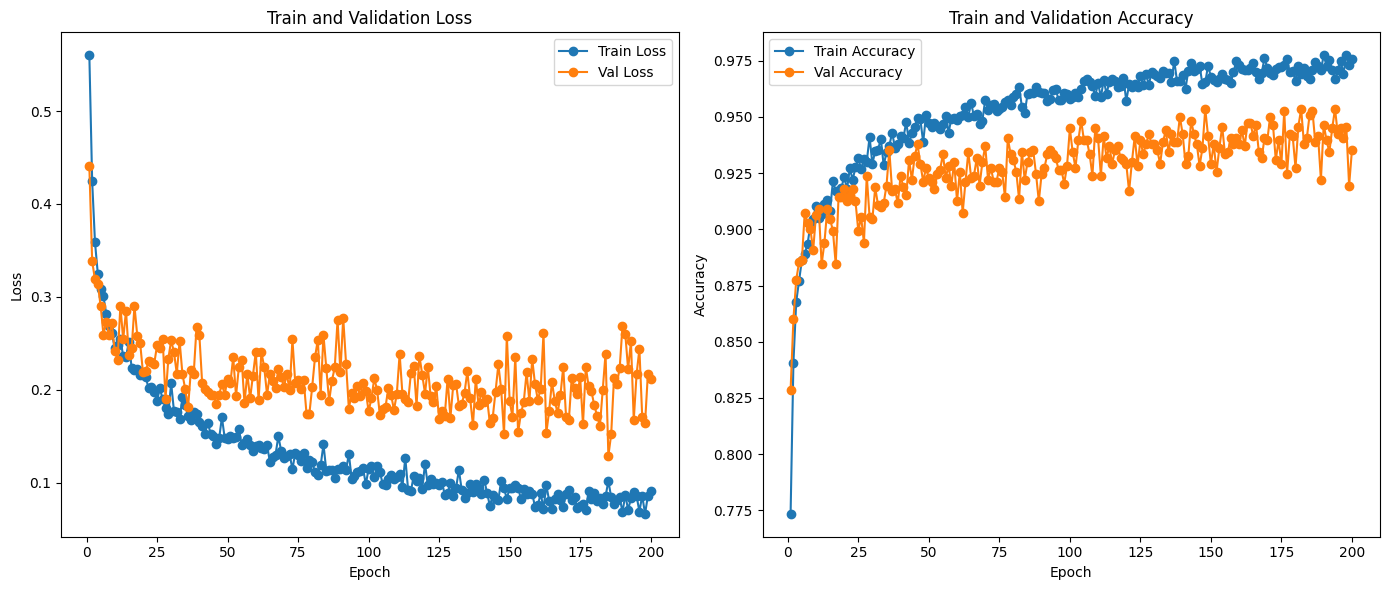

In [17]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ann_model.parameters(), lr=learning_rate)
checkpoint_path = 'best_model.pth'

best_val_loss = float('inf')

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(epochs):
    feature_extractor.train()
    ann_model.train()

    train_loss = 0
    correct_train = 0
    total_train = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        features = feature_extractor(images)
        pca_features = apply_pca(features, pca)
        pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)
        outputs = ann_model(pca_features)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_losses.append(train_loss / train_size)
    train_accuracies.append(correct_train / total_train)

    feature_extractor.eval()
    ann_model.eval()

    val_loss = 0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            features = feature_extractor(images)

            # Apply PCA
            pca_features = apply_pca(features, pca)
            pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)

            # Forward pass through ANN
            outputs = ann_model(pca_features)
            loss = criterion(outputs, labels)

            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_losses.append(val_loss / val_size)
    val_accuracies.append(correct_val / total_val)

    print(f"Epoch [{epoch + 1}/{epochs}], Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}")
    print(f"Epoch [{epoch + 1}/{epochs}], Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}")

    # Checkpointing (Optional: Save the best model based on validation loss)
    if val_losses[-1] < best_val_loss:
        torch.save(ann_model.state_dict(), 'ann_classifier.pth')
        torch.save(feature_extractor.state_dict(), 'unet_feature_extractor.pth')
        best_val_loss = val_losses[-1]
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': ann_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_losses[-1],
        }, checkpoint_path)
        print(f"Checkpoint saved at epoch {epoch + 1}")

# Load the best checkpoint after training
checkpoint = torch.load(checkpoint_path)
ann_model.load_state_dict(checkpoint['model_state_dict'])

# Plot the training and validation loss and accuracy
epochs_range = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label='Train Loss', marker='o')
plt.plot(epochs_range, val_losses, label='Val Loss', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(epochs_range, val_accuracies, label='Val Accuracy', marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Train and Validation Accuracy')
plt.legend()

plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import classification_report

# After the training loop, during validation

# Initialize lists to store true and predicted labels for the validation set
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
feature_extractor.eval()
ann_model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Extract features using the feature extractor
        features = feature_extractor(images)
        
        # Apply PCA to reduce dimensionality
        pca_features = apply_pca(features, pca)
        pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)
        
        # Get ANN model outputs
        outputs = ann_model(pca_features)
        
        # Get the predicted class for each image
        _, predicted = torch.max(outputs, 1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate the classification report
report = classification_report(true_labels, predicted_labels, target_names=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
print(report)


              precision    recall  f1-score   support

     Class 0       0.97      0.94      0.95       241
     Class 1       0.90      0.93      0.91       290
     Class 2       0.98      0.97      0.97       313
     Class 3       0.96      0.96      0.96       299

    accuracy                           0.95      1143
   macro avg       0.95      0.95      0.95      1143
weighted avg       0.95      0.95      0.95      1143



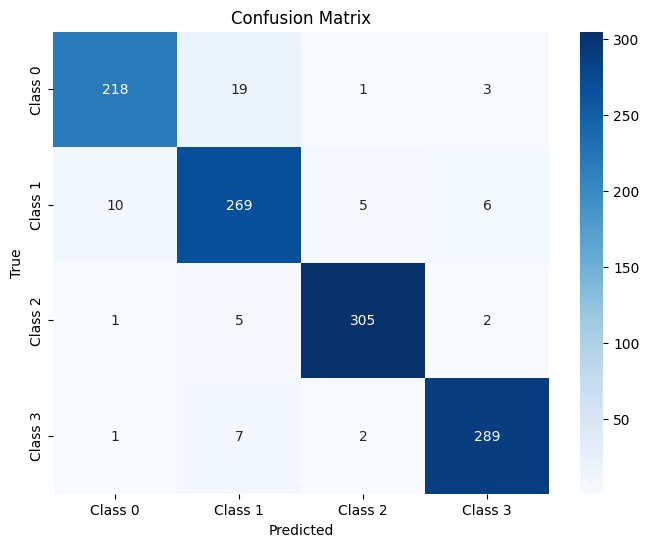

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize lists to store true and predicted labels for the validation set
true_labels = []
predicted_labels = []

# Set the model to evaluation mode
feature_extractor.eval()
ann_model.eval()

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        
        # Extract features using the feature extractor
        features = feature_extractor(images)
        
        # Apply PCA to reduce dimensionality
        pca_features = apply_pca(features, pca)
        pca_features = torch.tensor(pca_features, dtype=torch.float32).to(device)
        
        # Get ANN model outputs
        outputs = ann_model(pca_features)
        
        # Get the predicted class for each image
        _, predicted = torch.max(outputs, 1)
        
        # Store true and predicted labels
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

# Generate confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'], yticklabels=['Class 0', 'Class 1', 'Class 2', 'Class 3'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, transforms, datasets
import cv2
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

class GradCAM:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activation = None
        target_layer.register_forward_hook(self.save_activation)
        target_layer.register_backward_hook(self.save_gradient)
    
    def save_activation(self, module, input, output):
        self.activation = output

    def save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0]
    
    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax().item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        return self.compute_cam()

    def compute_cam(self):
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = F.relu(torch.sum(weights * self.activation, dim=1)).squeeze()
        cam = cam.cpu().detach().numpy()
        cam = cv2.resize(cam, (256, 256))
        cam = (cam - cam.min()) / (cam.max() - cam.min())
        return cam